# Topic Modelling For Business




## Dataset Description

The digital economy dataset hosts 2488 articles in this topic. The summary of each topic will be used as the base for the topic models.

### Importing Libraries

In [1]:
# Importing modules
import pandas as pd
import os

import numpy as np
import re, nltk, spacy, gensim

import logging
import warnings

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

warnings.filterwarnings('ignore')  

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [21]:
df = pd.read_csv('DigitalEconomyDatasetTM.csv')

In [22]:
df.head()

,Authors,Title,Year,Abstract,Keywords
0,"Nguyen Q.K., Dang Q.V.",Blockchain Technology - Opportunities for Emer...,2018,The recent major scientific conferences on the...,blockchain; digitaltechnology; distributed dia...
1,"Melnyk M., Korcelli-Olejniczak E., Chorna N., ...",Development of regional IT clusters in Ukraine...,2018,Introduction. Accelerated introduction of mode...,Country’s Innovation Ecosystem; Development of...
2,"Reisman R., Bertini M.",A novel architecture to monetize digital offer...,2018,As commerce continues to shift to the digital ...,Digital goods; Electronic commerce; Price disc...
3,"Bertola P., Teunissen J.",Fashion 4.0. Innovating fashion industry throu...,2018,Purpose: The on-going transition of societies ...,Design driven companies; Digital transformatio...
4,Moreno de la Santa J.G.-S.,The travel industry in 2018 – setting the scen...,2018,Purpose: The purpose of the paper is to identi...,China; Digital transformation; Global economy;...


In [23]:
df.shape

(2488, 5)

### Preprocessing the Data

In [24]:
# abstract will be used to model topics

df['Abstract'].head()

0    The recent major scientific conferences on the...
1    Introduction. Accelerated introduction of mode...
2    As commerce continues to shift to the digital ...
3    Purpose: The on-going transition of societies ...
4    Purpose: The purpose of the paper is to identi...
Name: Abstract, dtype: object

In [25]:
# Drop rows with no abstract available

df.drop(df[df['Abstract'] =='[No abstract available]'].index, inplace = True)

In [26]:
df.shape

(2423, 5)

In [27]:
import re

# Remove punctuation
df['p_abstract'] = df['Abstract'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['p_abstract'] = df['Abstract'].map(lambda x: x.lower())

# Print out the first rows of papers
df['p_abstract'].head()

0    the recent major scientific conferences on the...
1    introduction. accelerated introduction of mode...
2    as commerce continues to shift to the digital ...
3    purpose: the on-going transition of societies ...
4    purpose: the purpose of the paper is to identi...
Name: p_abstract, dtype: object

### Exploratory Analysis with WordCloud

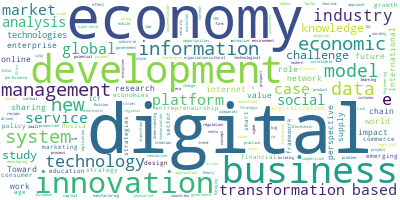

In [28]:
from wordcloud import WordCloud

# Join the different titles together.
long_string = ','.join(list(df['Title'].values))

# Generate the word cloud
wordcloud = WordCloud(background_color = "white",
                     max_words = 500,
                     contour_width = 3,
                     contour_color = "steelblue",
                     collocations= False).generate(long_string)

# Visualize the word cloud for titles
wordcloud.to_image()

Exercise: Build a wordcloud with top 200 words using Abstract field.

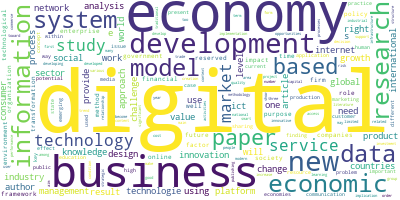

In [29]:

long_string_2 = ','.join(list(df['p_abstract'].values))

# Generate the word cloud
wordcloud2 = WordCloud(background_color = "white",
                     max_words = 200,
                     contour_width = 3,
                     contour_color = "steelblue",
                     collocations= False).generate(long_string_2)

# Visualize the word cloud for titles
wordcloud2.to_image()

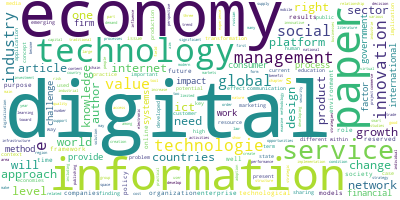

In [30]:
## Remove STOPWORDS taking reference from previous wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["research", "economic", "study", "data", "development", "result", "analysis", "model", 
                 "based", "using", "new", "market", "business", "system", "use"])

# Generate the word cloud
wordcloud3 = WordCloud( stopwords=stopwords,
                     background_color = "white",
                     max_words = 200,
                     contour_width = 3,
                     contour_color = "steelblue",
                     collocations= False).generate(long_string_2)

# Visualize the word cloud
wordcloud3.to_image()

### Data Preparation for Topic Modelling

In [31]:
%%time
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc = True))
        
data = df['p_abstract'].values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'recent', 'major', 'scientific', 'conferences', 'on', 'the', 'innovatube', 'frontier', 'ifs', 'have', 'focused', 'on', 'four', 'areas', 'of', 'pioneering', 'technologies', 'including', 'artificial', 'intelligence', 'internet', 'of', 'things', 'blockchain', 'and', 'augmented', 'reality', 'virtual', 'reality', 'blockchain', 'has', 'gained', 'lot', 'of', 'attention', 'because', 'not', 'only', 'it', 'is', 'the', 'technology', 'that', 'has', 'created', 'the', 'fever', 'of', 'the', 'bitcoin', 'and', 'ethereum', 'digital', 'coins', 'but', 'also', 'because', 'of', 'its', 'great', 'potentials', 'that', 'can', 'change', 'the', 'nature', 'of', 'the', 'real', 'world', 'and', 'in', 'everyone', 'lives', 'there', 'have', 'been', 'various', 'studies', 'on', 'blockchain', 'however', 'in', 'reality', 'the', 'percentage', 'of', 'people', 'who', 'understand', 'blockchain', 'remain', 'minute', 'this', 'paper', 'will', 'highlight', 'the', 'important', 'role', 'of', 'blockchain', 'technology', 'in',

In [32]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100)                      
# higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold = 100)    
# Faster way to get a sentence formatted as a bigram or trigram
bigram_mod = gensim.models.phrases.Phraser(bigram)    
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [38]:
# Remove Stop words

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['research', 'study', 'data', 'development', 'result', 'analysis', 'model', 
                 'based', 'using', 'new', 'market', 'business', 'system', 'use'])

# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp("  ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_  in allowed_postags])
    return texts_out
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# Lemmatization

# Remove Stop Words
data_words_nostops =remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])

# Lemmatize keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'] )

print(data_lemmatized[:1])

[['recent', 'major', 'scientific', 'conference', 'innovatube', 'frontier', 'if', 'focus', 'area', 'pioneer', 'technology', 'include', 'internet', 'thing', 'blockchain', 'augmented_reality', 'virtual', 'reality', 'blockchain', 'gain', 'lot', 'attention', 'technology', 'create', 'fever', 'bitcoin', 'ethereum', 'digital', 'coin', 'also', 'great', 'potential', 'change', 'nature', 'real', 'world', 'live', 'various', 'study', 'blockchain', 'however', 'reality', 'percentage', 'people', 'understand', 'blockchain', 'remain', 'minute', 'paper', 'highlight', 'important', 'role', 'blockchain', 'technology', 'future', 'world', 'especially', 'develop', 'country', 'ieee']]


In [40]:
# Building corpora

import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2)]]


### Building Topic Model

In [41]:
# Building LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus = corpus,
    id2word = id2word,
    num_topics = 10,
    random_state = 12,
    chunksize = 100,
    passes = 10,
    alpha = 0.01,
    eta = "auto",
    iterations = 400,
    per_word_topics = True
)

In [42]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"formation" + 0.020*"marketing" + 0.020*"medium" + 0.016*"network" + '
  '0.014*"control" + 0.014*"banking" + 0.013*"application" + 0.013*"skill" + '
  '0.012*"virtual" + 0.011*"labor"'),
 (1,
  '0.092*"bank" + 0.076*"payment" + 0.045*"india" + 0.031*"money" + '
  '0.030*"contract" + 0.028*"transaction" + 0.026*"financial" + 0.024*"cash" + '
  '0.015*"indian" + 0.014*"last"'),
 (2,
  '0.022*"management" + 0.016*"company" + 0.013*"model" + 0.013*"process" + '
  '0.011*"service" + 0.011*"knowledge" + 0.011*"system" + 0.011*"technology" + '
  '0.011*"innovation" + 0.010*"digital"'),
 (3,
  '0.099*"china" + 0.067*"chinese" + 0.066*"tourism" + 0.029*"cbec" + '
  '0.024*"clear" + 0.018*"intend" + 0.016*"boundary" + 0.014*"identifie" + '
  '0.013*"tourist" + 0.011*"progressive"'),
 (4,
  '0.027*"digital" + 0.025*"economic" + 0.025*"technology" + 0.022*"economy" + '
  '0.018*"information" + 0.017*"country" + 0.014*"tax" + 0.011*"develop" + '
  '0.010*"process" + 0.009*"sector"'),

In [44]:
from gensim.models import CoherenceModel

# Compute Perplexity
# A measure of how good the model is. Lower value is preferred.
print('Perplexity: ', lda_model.log_perplexity(corpus) )  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = "c_v")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = "u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score u_mass: ', coherence_lda)

Perplexity:  -8.345150293078639

Coherence Score:  0.39534950869868146

Coherence Score u_mass:  -5.933941293868199


### Visualizing the Model

In [47]:
# Visualize the topics
import pyLDAvis

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
pyLDAvis.enable_notebook()

from pyLDAvis import gensim_models 


vls =  pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vls

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.268300 -0.090268       1        1  35.174166
2      0.242674 -0.042471       2        1  18.529386
4      0.260030 -0.110326       3        1  16.793214
6      0.113597  0.062636       4        1   9.172491
0     -0.032920  0.224171       5        1   7.968547
5     -0.020875  0.267298       6        1   6.979982
9     -0.164635 -0.000462       7        1   2.411290
1     -0.222320 -0.117530       8        1   1.337911
7     -0.220770 -0.092078       9        1   0.952913
3     -0.223082 -0.100970      10        1   0.680102, topic_info=            Term         Freq        Total Category  logprob  loglift
328     industry  1124.000000  1124.000000  Default  30.0000  30.0000
94      economic  1828.000000  1828.000000  Default  29.0000  29.0000
405       online   704.000000   704.000000  Default  28.0000  28.0000
143   management  1261.000000  1261.000000  Default  27.0000  27.0000
590         work   832.000000   832.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1637       arena     8.578348     9.407010  Topic10  -5.3007   4.8985
4246      island     8.156557     8.985325  Topic10  -5.3511   4.8939
5615     politic     7.249419     8.077988  Topic10  -5.4690   4.8825
1635  accumulate     7.016449     7.845153  Topic10  -5.5016   4.8790
6859  optimistic     6.401937     7.230731  Topic10  -5.5933   4.8689

[514 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3665      3  0.985265      absence
592       2  0.994258       accord
1635     10  0.892271   accumulate
1485      7  0.987445  acknowledge
1486      7  0.986174      acquire
...     ...       ...          ...
51        5  0.013885        world
51        6  0.041655        world
800       4  0.719922         year
800       5  0.222415         year
800       8  0.052677         year

[738 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 5, 7, 1, 6, 10, 2, 8, 4])